<a href="https://colab.research.google.com/github/Vignesh-397/Image_Dehazing/blob/main/Training_Part/Image_Dehazing_By_Resizing_Training_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing libraries**



In [ ]:
import os
import numpy as np
import shutil
import glob
import cv2
import matplotlib.pyplot as plt
import glob

import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import ModelCheckpoint

## **Specifying paths for dataset**

In [ ]:
train_hazy_path = glob.glob('/content/drive/MyDrive/Samsung Prism/dataset/train/hazy/*')
val_hazy_path = glob.glob('/content/drive/MyDrive/Samsung Prism/dataset/val/hazy/*')

gt_paths = '/content/drive/MyDrive/Samsung Prism/dataset/train/clear/'
val_gt_paths = '/content/drive/MyDrive/Samsung Prism/dataset/val/clear/'

savepath ="/content/outdoorunet-{epoch:02d}-{loss:.4f}.keras"

batch_size = 6

## **Image loading to train dataset**

In [ ]:
# get images in batch
def get_images(path):
    imgs = []
    for i in path:
        img = cv2.imread(i)/255.
        I = img

        l = cv2.resize(I, (256, 256))

        imgs.append(l)

    return imgs

def get_gt_images(path, gt_path):
    imgs = []
    for hazy_image_path in path:
        filename = os.path.basename(hazy_image_path)

        gt_image_path = os.path.join(gt_path, filename)

        img = cv2.imread(gt_image_path)
        I = img / 255.0
        l = cv2.resize(I, (256, 256))

        imgs.append(l)

    return imgs

## **Loading images as batches for training and validation**

In [ ]:
def train_generator(train_path, batch_size):
    L = len(train_path)
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            # X_load as input images
            X_load = get_images(train_path[batch_start:limit])
            # Y_load as ground truth images
            Y_load = get_gt_images(train_path[batch_start:limit], gt_paths)

            # Stack the images load as batch
            X = np.stack(X_load, axis=0)
            Y = np.stack(Y_load, axis=0)

            batch_start += batch_size
            batch_end += batch_size

            yield (X, Y)

def val_generator(val_path, batch_size):
    L = len(val_path)
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X_load = get_images(val_path[batch_start:limit])
            Y_load = get_gt_images(val_path[batch_start:limit], val_gt_paths)
            X = np.stack(X_load, axis=0)
            Y = np.stack(Y_load, axis=0)

            batch_start += batch_size
            batch_end += batch_size

            yield (X, Y)


## **Create the VGG model and define loss function**

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
content_layer = 'block2_conv2'
loss_model = Model(vgg.input, vgg.get_layer(content_layer).output)

# Perceptual loss using VGG19
def lossVGG(y_true, y_pred, loss_model):
    vggX = loss_model(y_pred)
    vggY = loss_model(y_true)
    return K.mean(K.square(vggX - vggY))

# Total loss
def my_loss(y_true, y_pred):
    mse = MSE(y_true, y_pred)
    return lossVGG(y_true, y_pred, loss_model) + mse

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## **Model implementation**

In [ ]:
def dseu():
    inputs = Input((None, None, 3))

    # Encoder part
    conv1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    dilate1 = Conv2D(256, (3, 3), padding='same', dilation_rate=1, kernel_initializer='he_normal')(pool4)
    dilate1 = BatchNormalization()(dilate1)
    dilate1 = Activation('relu')(dilate1)
    dilate2 = Conv2D(256, (3, 3), padding='same', dilation_rate=2, kernel_initializer='he_normal')(pool4)
    dilate2 = BatchNormalization()(dilate2)
    dilate2 = Activation('relu')(dilate2)
    dilate3 = Conv2D(256, (3, 3), padding='same', dilation_rate=4, kernel_initializer='he_normal')(pool4)
    dilate3 = BatchNormalization()(dilate3)
    dilate3 = Activation('relu')(dilate3)
    dilate4 = Conv2D(256, (3, 3), padding='same', dilation_rate=8, kernel_initializer='he_normal')(pool4)
    dilate4 = BatchNormalization()(dilate4)
    dilate4 = Activation('relu')(dilate4)

    convm = concatenate([dilate1, dilate2, dilate3, dilate4], axis=3)

    # Decoder part
    up6 = UpSampling2D(size=(2, 2))(convm)
    up6 = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal')(up6)
    up6 = BatchNormalization()(up6)
    up6 = Activation('relu')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, (2, 2), padding='same', kernel_initializer='he_normal')(up7)
    up7 = BatchNormalization()(up7)
    up7 = Activation('relu')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, (2, 2), padding='same', kernel_initializer='he_normal')(up8)
    up8 = BatchNormalization()(up8)
    up8 = Activation('relu')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, (2, 2), padding='same', kernel_initializer='he_normal')(up9)
    up9 = BatchNormalization()(up9)
    up9 = Activation('relu')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Activation('sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

## **Compiling the model**

In [ ]:
model = dseu()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=my_loss, metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 64) │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 64) │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 64) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 64) │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 64) │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None,     │         73,856 │ max_pooling2d[0][0]    │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None,     │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None,     │              0 │ batch_normalization_2… │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None,     │        147,584 │ activation_2[0][0]     │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None,     │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None,     │              0 │ batch_normalization_3… │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1      

 Total params: 21,618,499 (82.47 MB)

 Trainable params: 21,606,851 (82.42 MB)

 Non-trainable params: 11,648 (45.50 KB)

## **Define checkpoint**

In [ ]:
model_checkpoint = ModelCheckpoint(savepath, monitor='loss', verbose=1, save_best_only=True)

## **Training the Model**

In [ ]:
history = model.fit(
    train_generator(train_hazy_path, batch_size),
    steps_per_epoch=len(train_hazy_path) // batch_size,
    epochs=20,
    verbose=1,
    callbacks=[model_checkpoint],
)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4960 - loss: 3.8512
Epoch 1: loss improved from inf to 2.24626, saving model to /content/outdoorunet-01-2.2463.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 1269s 8s/step - accuracy: 0.4961 - loss: 3.8411
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.5025 - loss: 1.0067
Epoch 2: loss improved from 2.24626 to 0.96207, saving model to /content/outdoorunet-02-0.9621.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 118s 517ms/step - accuracy: 0.5026 - loss: 1.0064
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.5177 - loss: 0.8984
Epoch 3: loss improved from 0.96207 to 0.81357, saving model to /content/outdoorunet-03-0.8136.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.5178 - loss: 0.8978
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.5325 - loss: 0.8711
Epoch 4: loss improved from 0.81357 to 0.72747, saving model to /content/outdoorunet-04-0.7275.keras
158/158 ━━━━━━━━━

## **Visualize the accuracy and loss**

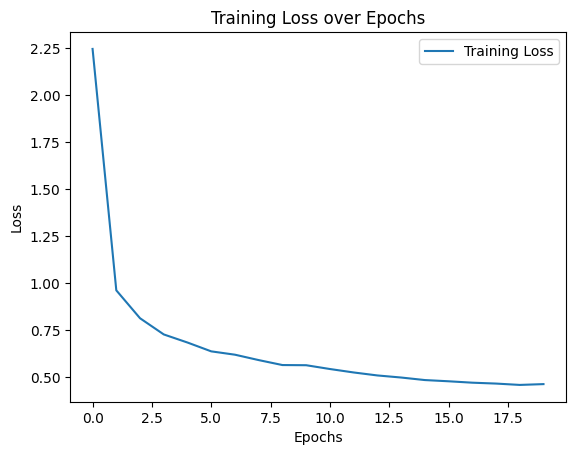

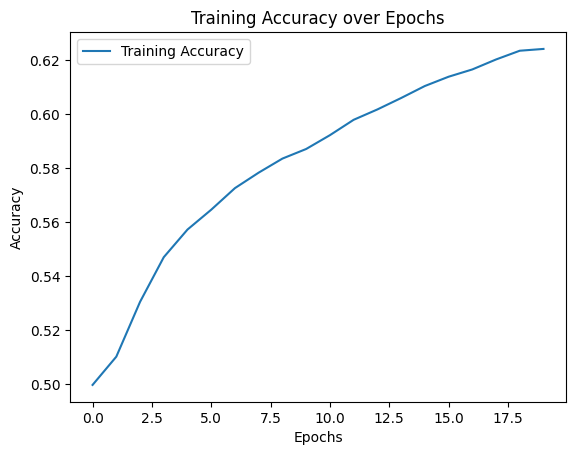

In [ ]:
# Plot Training Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.legend()
    plt.show()


## **Saving the model**

In [ ]:
model.save('/content/dehazing_model.keras')
model.save('/content/drive/MyDrive/Samsung Prism/dehazing_model.keras')